In [268]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


In [269]:
# df = pd.read_csv('In-Progress_cleaned.csv')
df = pd.read_csv('Complete_cleaned.csv')

# df.columns.tolist()

In [270]:
df = df[[
    'failure', 
    'project_phase_name', 
    'project_budget_amount', 
    'total_phase_actual_spending_amount', 
    'over_budget_amount', 
    'over_budget_percentage',
    'borough', 
    'start_and_planned_end_diff',
    'project_type',
    # 'project_type_SCA',
    # 'project_type_CIP',
    # 'project_type_DIIT',
    # 'project_type_DOE',
    # 'project_type_DOES',
    # 'project_type_DOER',
    # 'project_type_RESOA',
    # 'project_type_IEH',
    # 'project_type_PRE-K',
    # 'project_type_DCAS',
    # 'project_type_FAST_TRACK_PROJECTS',
]]
df.fillna(0, inplace=True)

df['over_budget_percentage'].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['over_budget_percentage'], inplace=True)

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_54689/537208604.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['over_budget_percentage'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [271]:
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# Convert non-numeric columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)
df.replace({True: 1, False: 0}, inplace=True)


/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_54689/1259965533.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [272]:
X = df.drop('failure', axis=1)
y = df['failure']

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)

(1906, 33)
(1906,)


In [274]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data and resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(3526, 33)
(3526,)


In [275]:
# # Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [276]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       754
           1       0.82      0.80      0.81        64

    accuracy                           0.97       818
   macro avg       0.90      0.89      0.90       818
weighted avg       0.97      0.97      0.97       818



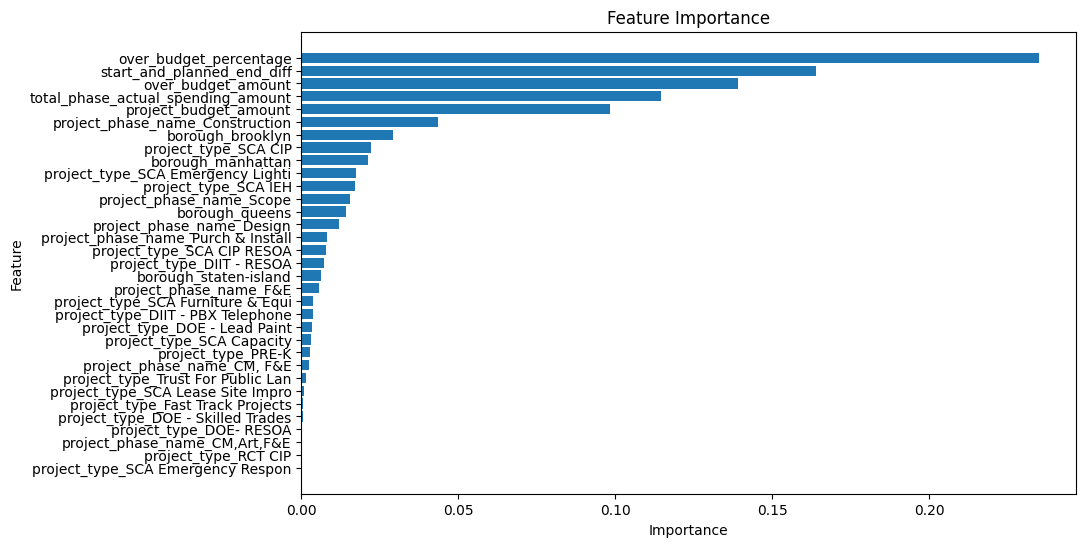

In [277]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [278]:
import shap 
import numpy as np

explainer = shap.Explainer(model, X_train_resampled)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Convert the SHAP values object to a list of arrays
shap_values_list = [shap_values[:, :, i].values for i in range(shap_values.values.shape[2])]

# Combine the SHAP values for all classes by summing the absolute values across classes
shap_values_combined = np.sum(np.abs(shap_values_list), axis=0)

 95%|=================== | 1551/1636 [00:13<00:00]       

In [279]:
# shap_values_combined

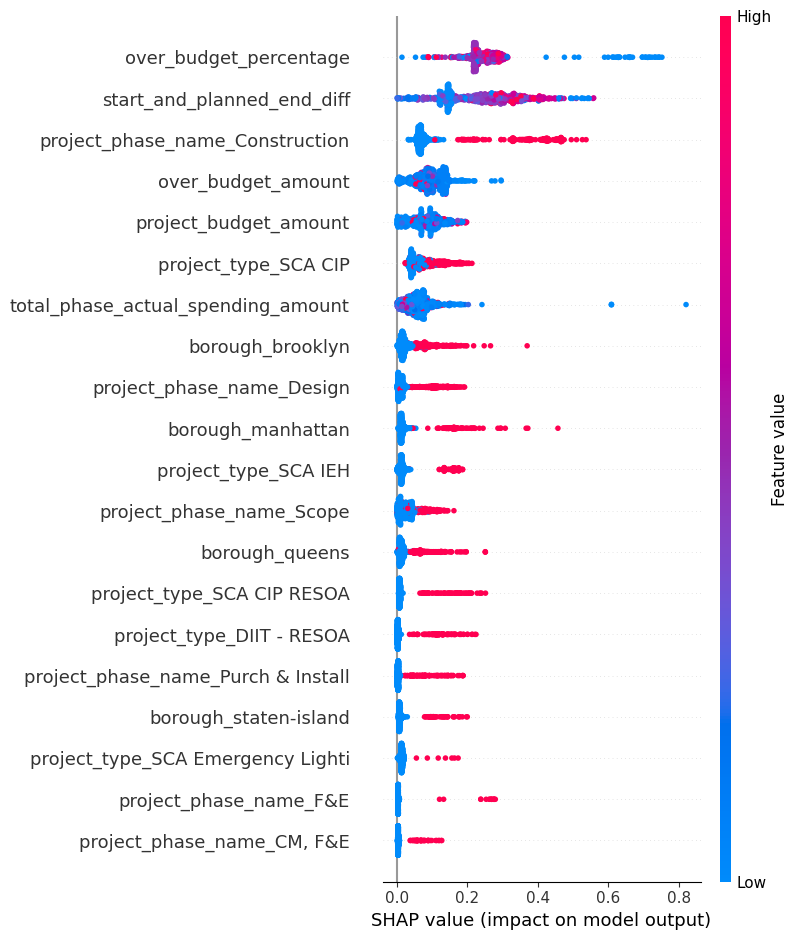

In [280]:
assert shap_values_combined.shape == X_test.shape, "SHAP values and data matrix shapes do not match!"
shap.summary_plot(shap_values_combined, X_test)

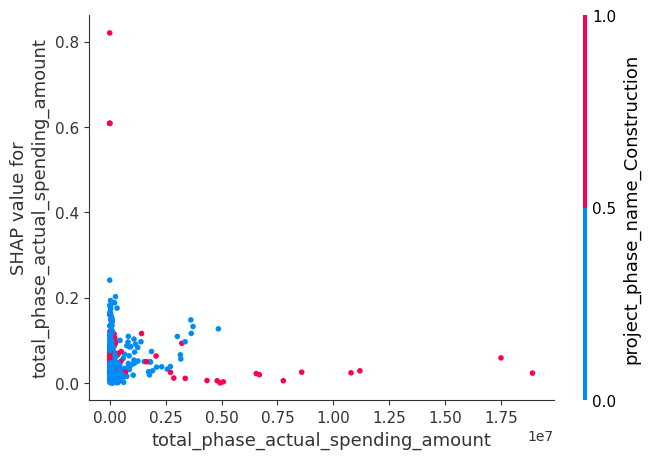

In [281]:
shap.dependence_plot("total_phase_actual_spending_amount", shap_values_combined, X_test, interaction_index="project_phase_name_Construction")